     |████████████████████████████████| 102kB 4.8MB/s 
11493376/11490434 [==============================] - 0s 0us/step


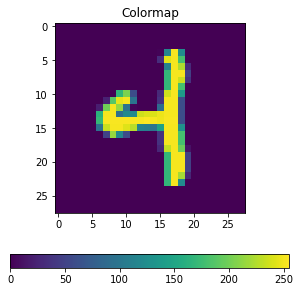

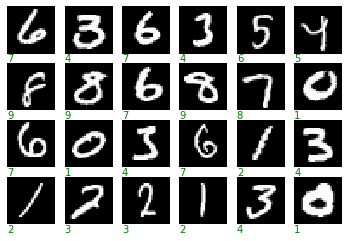

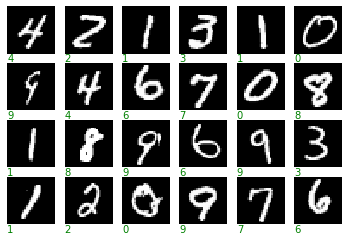

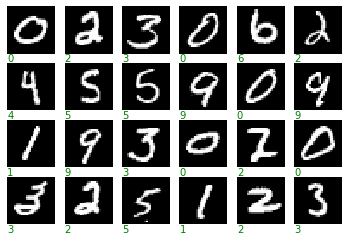

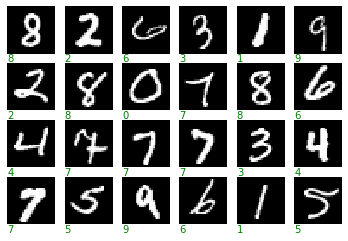

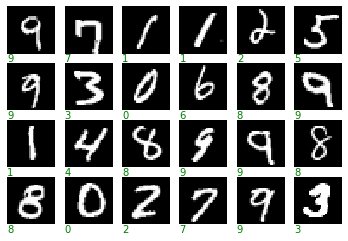

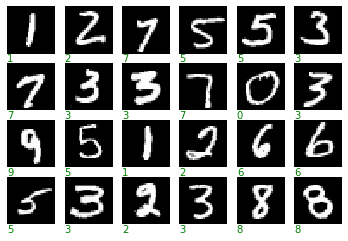

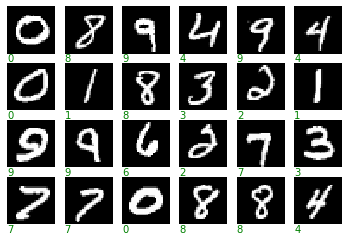

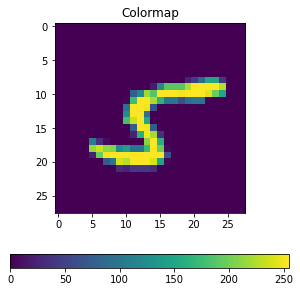

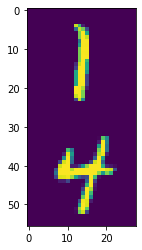

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Jun 12 09:44:18 2021

@author: raedb
"""

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io
import random
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import cv2
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
!pip install scikit-optimize
import skopt
from skopt import gbrt_minimize, gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer  
from tensorflow.python.keras import backend as K
import scipy.optimize as optimize
from scipy.optimize import Bounds

def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j]+1)%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k]+1)%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "train")
    ax1.plot(history.history['val_loss'], label = "val")
    ax2.plot(history.history['accuracy'], label = "train")
    ax2.plot(history.history['val_accuracy'], label = "val")
    finalize_standardplot(fig, ax1, ax2)
    return fig


def define_model():
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', 
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(0.01),
                                     ))    #input_shape=(56, 28, 1)
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', 
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(0.01),
                                     ))    
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Conv2D(128, (3, 3), activation='relu', 
                                     kernel_initializer='he_uniform',
                                     kernel_regularizer=regularizers.l2(0.01),
                                     ))    
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', 
                             kernel_initializer='he_uniform',
                             kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(2, activation='softmax'))
    # compile model
    return model


# downloads data at first execution
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = keras.datasets.mnist.load_data(path="mnist.npz")


subset_size = 20000
x_mnist_train = x_mnist_train[0:subset_size,:,:]
y_mnist_train = y_mnist_train[0:subset_size]
x_mnist_test = x_mnist_test[0:subset_size,:,:]
y_mnist_test = y_mnist_test[0:subset_size]

## Explore scale to know if scaling is necessary ##
plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.title('Colormap')
plt.imshow(x_mnist_train[np.random.randint(0,x_mnist_train.shape[0])])
plt.colorbar(orientation="horizontal")
plt.grid(False)
plt.show()


#MNIST
## Plot some samples of the dataset with labels  ##
plot_some_samples(x_mnist_train, y_mnist_train)

## change labels to right ones in images
y_mnist_train = y_mnist_train.astype(np.float32) - 1
y_mnist_train = np.where(y_mnist_train==-1, 9, y_mnist_train)
y_mnist_train = y_mnist_train.astype(np.uint8)
y_mnist_test = y_mnist_test.astype(np.float32) - 1
y_mnist_test = np.where(y_mnist_test==-1, 9, y_mnist_test)
y_mnist_test = y_mnist_test.astype(np.uint8)

### plot sample to check if labeling is done properly
plot_some_samples(x_mnist_train, y_mnist_train)
plot_some_samples(x_mnist_test, y_mnist_test)

# shuffle 2 versions of the training set to build input
x_train_0, y_train_0    = shuffle(x_mnist_train, y_mnist_train)
x_train_1, y_train_1    = shuffle(x_mnist_train, y_mnist_train)
plot_some_samples(x_train_0, y_train_0)
plot_some_samples(x_train_1, y_train_1)

# shuffle 2 versions of the testing set to build input
x_test_0, y_test_0      = shuffle(x_mnist_test, y_mnist_test)
x_test_1, y_test_1      = shuffle(x_mnist_test, y_mnist_test)
plot_some_samples(x_test_0, y_test_0)
plot_some_samples(x_test_1, y_test_1)

# scale training data to 0,1
x_train_0 = x_train_0 / 255
x_train_1 = x_train_1 / 255
x_test_0  = x_test_0 / 255 
x_test_1 = x_test_1 / 255

## Explore scaled data to know if scaling is necessary ##
plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.title('Colormap')
plt.imshow(x_mnist_train[np.random.randint(0,x_train_0.shape[0])])
plt.colorbar(orientation="horizontal")
plt.grid(False)
plt.show()

# horizentally append images from set 0 and 1 to create input images
x_train = cv2.hconcat([x_train_0, x_train_1])
plt.imshow(x_train[0])
x_test  = cv2.hconcat([x_test_0, x_test_1])
plt.imshow(x_test[0])

# create output labels
diff_train = y_train_0.astype(np.float32) - y_train_1.astype(np.float32)
diff_test  = y_test_0.astype(np.float32)   - y_test_1.astype(np.float32)

y_train = np.where(diff_train > 0, 1, diff_train)
y_train = np.where(y_train < 0, 0, y_train).astype(np.uint8)
y_test = np.where(diff_test > 0, 1, diff_test)
y_test = np.where(y_test < 0, 0, y_test).astype(np.uint8)

y_train = np.flip(keras.utils.to_categorical(y_train, num_classes=2), axis=1).astype(np.uint8)
y_test = np.flip(keras.utils.to_categorical(y_test, num_classes=2), axis=1).astype(np.uint8)

# define validation data
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

# reshape data, add 1 dimension because of CNN insput: 1 channel
x_train = x_train.reshape((x_train.shape[0], 56, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 56, 28, 1))
x_val = x_val.reshape((x_val.shape[0], 56, 28, 1))

In [ ]:
# define optimization variables and ranges
dim_learning_rate = Real(low=1e-4, high=1e-1, prior='log-uniform',
                         name='learning_rate')
dimensions = [dim_learning_rate]
default_parameters = [5*1e-4,7.5*1e-3,5*1e-2]


@use_named_args(dimensions=dimensions)
def fitness(learning_rate):
    model = define_model()
    opt = SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    structure =  model.fit(x_train, y_train, 
                           validation_data=(x_val, y_val), 
                           epochs = 5, batch_size = 64)
    accuracy = structure.history['val_accuracy'][-1]
    
    print()
    print("Learning rate: {0:.6}".format(learning_rate))
    print("Accuracy: {0:.2%}".format(accuracy))
    print()
    
    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear session
    K.clear_session()
    
    # the optimizer aims for the lowest score, so we return our negative accuracy
    return -accuracy


K.clear_session() # clear previous models in session

In [ ]:
gp_results = []
for default_lr in default_parameters:
    print("*****************************************************")
    print("Running optimizer for LR0: {0:.6}".format(default_lr))
    print("*****************************************************")
    gp_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            n_calls=12,
                            noise= 0.01,
                            n_jobs=-1,
                            kappa = 5,
                            x0=[default_lr])
    gp_results.append(gp_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************
Epoch 1/5
250/250 [==============================] - 34s 8ms/step - loss: 10.0598 - accuracy: 0.6669 - val_loss: 9.6855 - val_accuracy: 0.7092
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 9.4172 - accuracy: 0.7604 - val_loss: 9.1289 - val_accuracy: 0.8002
Epoch 3/5
250/250 [==============================] - 1s 6ms/step - loss: 8.9232 - accuracy: 0.7929 - val_loss: 8.6536 - val_accuracy: 0.8263
Epoch 4/5
250/250 [==============================] - 1s 6ms/step - loss: 8.4748 - accuracy: 0.8106 - val_loss: 8.2183 - val_accuracy: 0.8413
Epoch 5/5
250/250 [==============================] - 1s 6ms/step - loss: 8.0550 - accuracy: 0.8230 - val_loss: 7.8209 - val_accuracy: 0.8515

Learning rate: 0.0005
Accuracy: 85.15%

Epoch 1/5
250/250 [==============================] - 2s 7ms/step - loss: 2.4514 - accuracy: 0.8189 - val_loss:

In [ ]:
for i in range(len(default_parameters)):
  print('x0:',default_parameters[i],'Learning-rate', gp_results[i].x[0],'Accuracy', -gp_results[i].fun*100,'%')


x0: 0.0005 Learning-rate 0.013925463895232042 Accuracy 94.70000267028809 %
x0: 0.0075 Learning-rate 0.0072600859242723794 Accuracy 93.90000104904175 %
x0: 0.05 Learning-rate 0.01158724684313094 Accuracy 95.3000009059906 %


In [ ]:
Nelder_Mead_results = []
for default_lr in default_parameters:  
  print("*****************************************************")
  print("Running optimizer for LR0: {0:.6}".format(default_lr))
  print("*****************************************************")  
  Nelder_Mead_result = optimize.minimize(fitness, 
                                     x0=default_lr, 
                                     method='Nelder-Mead',
                                     options={'maxiter':10, 'maxfev':10,'disp':True, 'return_all':True}, 
                                     bounds=((1e-4,1e-1),))
  Nelder_Mead_results.append(Nelder_Mead_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  RuntimeWarning)


250/250 [==============================] - 3s 8ms/step - loss: 10.0996 - accuracy: 0.6801 - val_loss: 9.7066 - val_accuracy: 0.7680
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 9.4821 - accuracy: 0.7624 - val_loss: 9.1744 - val_accuracy: 0.8177
Epoch 3/5
250/250 [==============================] - 2s 6ms/step - loss: 8.9911 - accuracy: 0.7918 - val_loss: 8.7093 - val_accuracy: 0.8347
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 8.5485 - accuracy: 0.8070 - val_loss: 8.2814 - val_accuracy: 0.8460
Epoch 5/5
250/250 [==============================] - 2s 7ms/step - loss: 8.1236 - accuracy: 0.8234 - val_loss: 7.8769 - val_accuracy: 0.8537

Learning rate: 0.0005
Accuracy: 85.37%

Epoch 1/5
250/250 [==============================] - 3s 8ms/step - loss: 9.9814 - accuracy: 0.7024 - val_loss: 9.5804 - val_accuracy: 0.7797
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 9.3549 - accuracy: 0.7769 - val_loss: 9.0404 - va

In [ ]:
for i in range(len(default_parameters)):
  print('x0:',default_parameters[i],'Learning-rate', Nelder_Mead_results[i].x[0],'Accuracy', -Nelder_Mead_results[i].fun*100,'%')

x0: 0.0005 Learning-rate 0.0005187500000000001 Accuracy 86.07500195503235 %
x0: 0.0075 Learning-rate 0.0073124999999999996 Accuracy 95.22500038146973 %
x0: 0.05 Learning-rate 0.05500000000000001 Accuracy 89.47499990463257 %


In [ ]:
L_BFGS_results = []
for default_lr in default_parameters:  
  print("*****************************************************")
  print("Running optimizer for LR0: {0:.6}".format(default_lr))
  print("*****************************************************")  
  L_BFGS_result = optimize.minimize(fitness, 
                                     x0=default_lr, 
                                     method='L-BFGS-B',
                                     options={'maxiter':10, 'maxfun':10,'disp':True, 'return_all':True}, 
                                     bounds=((1e-4,1e-1),))
  L_BFGS_results.append(L_BFGS_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method L-BFGS-B does not support the return_all option.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: return_all
  # Remove the CWD from sys.path while we load stuff.


250/250 [==============================] - 3s 7ms/step - loss: 9.9983 - accuracy: 0.6917 - val_loss: 9.6417 - val_accuracy: 0.7483
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 9.3973 - accuracy: 0.7644 - val_loss: 9.0943 - val_accuracy: 0.8138
Epoch 3/5
250/250 [==============================] - 2s 6ms/step - loss: 8.9019 - accuracy: 0.7990 - val_loss: 8.6316 - val_accuracy: 0.8328
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 8.4644 - accuracy: 0.8117 - val_loss: 8.2089 - val_accuracy: 0.8438
Epoch 5/5
250/250 [==============================] - 2s 7ms/step - loss: 8.0449 - accuracy: 0.8223 - val_loss: 7.8108 - val_accuracy: 0.8495

Learning rate: 0.0005
Accuracy: 84.95%

Epoch 1/5
250/250 [==============================] - 2s 7ms/step - loss: 10.0555 - accuracy: 0.6881 - val_loss: 9.6909 - val_accuracy: 0.7308
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 9.4279 - accuracy: 0.7679 - val_loss: 9.1419 - va

In [ ]:
for i in range(len(default_parameters)):
  print('x0:',default_parameters[i],'Learning-rate', L_BFGS_results[i].x[0],'Accuracy', -L_BFGS_results[i].fun*100,'%')

x0: 0.0005 Learning-rate 0.0005007416224239004 Accuracy 84.75000262260437 %
x0: 0.0075 Learning-rate 0.0075 Accuracy 94.30000185966492 %
x0: 0.05 Learning-rate 0.04999213034998947 Accuracy 66.72499775886536 %


In [ ]:
L_BFGS_results[1]

      fun: -0.9430000185966492
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([8925002.81333923])
  message: b'STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT'
     nfev: 40
      nit: 1
   status: 1
  success: False
        x: array([0.0075])

In [ ]:
CG_results = []
for default_lr in default_parameters:  
  print("*****************************************************")
  print("Running optimizer for LR0: {0:.6}".format(default_lr))
  print("*****************************************************")  
  CG_result = optimize.minimize(fitness, 
                                     x0=default_lr, 
                                     method='CG',
                                     options={'maxiter':10, 'maxfeval':10,'disp':True, 'return_all':True}, 
                                     bounds=((1e-4,1e-1),))
  CG_results.append(CG_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: maxfeval
  # Remove the CWD from sys.path while we load stuff.


250/250 [==============================] - 3s 8ms/step - loss: 10.0600 - accuracy: 0.6826 - val_loss: 9.6830 - val_accuracy: 0.7502
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 9.4461 - accuracy: 0.7638 - val_loss: 9.1468 - val_accuracy: 0.8148
Epoch 3/5
250/250 [==============================] - 1s 6ms/step - loss: 8.9610 - accuracy: 0.7903 - val_loss: 8.6818 - val_accuracy: 0.8320
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 8.5109 - accuracy: 0.8107 - val_loss: 8.2528 - val_accuracy: 0.8453
Epoch 5/5
250/250 [==============================] - 2s 6ms/step - loss: 8.1007 - accuracy: 0.8181 - val_loss: 7.8531 - val_accuracy: 0.8525

Learning rate: 0.0005
Accuracy: 85.25%

Epoch 1/5
250/250 [==============================] - 2s 7ms/step - loss: 9.9726 - accuracy: 0.6787 - val_loss: 9.6160 - val_accuracy: 0.7358
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 9.3578 - accuracy: 0.7662 - val_loss: 9.0815 - va

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: maxfeval
  # Remove the CWD from sys.path while we load stuff.


250/250 [==============================] - 3s 8ms/step - loss: 7.3876 - accuracy: 0.8038 - val_loss: 5.0761 - val_accuracy: 0.8167
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 3.5799 - accuracy: 0.8780 - val_loss: 2.6316 - val_accuracy: 0.8070
Epoch 3/5
250/250 [==============================] - 2s 6ms/step - loss: 1.8103 - accuracy: 0.9059 - val_loss: 1.3781 - val_accuracy: 0.8685
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 0.9752 - accuracy: 0.9246 - val_loss: 0.8294 - val_accuracy: 0.8888
Epoch 5/5
250/250 [==============================] - 2s 6ms/step - loss: 0.5806 - accuracy: 0.9429 - val_loss: 0.5163 - val_accuracy: 0.9243

Learning rate: 0.0075
Accuracy: 92.43%

Epoch 1/5
250/250 [==============================] - 2s 7ms/step - loss: 7.3685 - accuracy: 0.8167 - val_loss: 5.4343 - val_accuracy: 0.6217
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 3.5641 - accuracy: 0.8862 - val_loss: 2.7566 - val

/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: maxfeval
  # Remove the CWD from sys.path while we load stuff.


250/250 [==============================] - 2s 7ms/step - loss: 2.7819 - accuracy: 0.8379 - val_loss: 4.6134 - val_accuracy: 0.5605
Epoch 2/5
250/250 [==============================] - 2s 7ms/step - loss: 0.5936 - accuracy: 0.8754 - val_loss: 0.7001 - val_accuracy: 0.8065
Epoch 3/5
250/250 [==============================] - 2s 6ms/step - loss: 0.6022 - accuracy: 0.8791 - val_loss: 0.6709 - val_accuracy: 0.8480
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 0.6198 - accuracy: 0.8836 - val_loss: 0.6656 - val_accuracy: 0.8643
Epoch 5/5
250/250 [==============================] - 2s 6ms/step - loss: 0.5923 - accuracy: 0.8876 - val_loss: 0.9590 - val_accuracy: 0.7513

Learning rate: 0.05
Accuracy: 75.13%

Epoch 1/5
250/250 [==============================] - 2s 7ms/step - loss: 2.8710 - accuracy: 0.8338 - val_loss: 1.3357 - val_accuracy: 0.5605
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 0.5977 - accuracy: 0.8809 - val_loss: 0.8577 - val_a

In [ ]:
for i in range(len(default_parameters)):
  print('x0:',default_parameters[i],'Learning-rate', CG_results[i].x[0],'Accuracy', -CG_results[i].fun*100,'%')

x0: 0.0005 Learning-rate 0.0004946649334428675 Accuracy 85.35000085830688 %
x0: 0.0075 Learning-rate 0.0075 Accuracy 93.00000071525574 %
x0: 0.05 Learning-rate 0.0500179846037705 Accuracy 86.04999780654907 %


In [ ]:
CG_results

[ allvecs: [array([0.0005]), array([0.00049466])]
     fun: -0.8535000085830688
     jac: array([33556.])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 77
     nit: 1
    njev: 22
  status: 2
 success: False
       x: array([0.00049466]),
  allvecs: [array([0.0075])]
     fun: -0.9300000071525574
     jac: array([-134216.])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 71
     nit: 0
    njev: 20
  status: 2
 success: False
       x: array([0.0075]),
  allvecs: [array([0.05]), array([0.05001798])]
     fun: -0.8604999780654907
     jac: array([-2650800.])
 message: 'Desired error not necessarily achieved due to precision loss.'
    nfev: 69
     nit: 1
    njev: 19
  status: 2
 success: False
       x: array([0.05001798])]

In [ ]:
COBYLA_results = []
for default_lr in default_parameters:  
  print("*****************************************************")
  print("Running optimizer for LR0: {0:.6}".format(default_lr))
  print("*****************************************************")  
  COBYLA_result = optimize.minimize(fitness, 
                                     x0=default_lr, 
                                     method='COBYLA',
                                     options={'maxiter':10, 'maxfeval':10,'disp':True, 'return_all':True}, 
                                     bounds=((1e-4,1e-1),))
  COBYLA_results.append(COBYLA_result)

*****************************************************
Running optimizer for LR0: 0.0005
*****************************************************
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:528: RuntimeWarning: Method COBYLA cannot handle bounds.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:536: RuntimeWarning: Method COBYLA does not support the return_all option.
  RuntimeWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: OptimizeWarning: Unknown solver options: maxfeval, return_all
  # Remove the CWD from sys.path while we load stuff.


250/250 [==============================] - 2s 7ms/step - loss: 9.9396 - accuracy: 0.6874 - val_loss: 9.5651 - val_accuracy: 0.7713
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 9.3253 - accuracy: 0.7690 - val_loss: 9.0269 - val_accuracy: 0.8183
Epoch 3/5
250/250 [==============================] - 2s 6ms/step - loss: 8.8389 - accuracy: 0.8006 - val_loss: 8.5651 - val_accuracy: 0.8395
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 8.4029 - accuracy: 0.8139 - val_loss: 8.1432 - val_accuracy: 0.8505
Epoch 5/5
250/250 [==============================] - 2s 6ms/step - loss: 7.9910 - accuracy: 0.8244 - val_loss: 7.7481 - val_accuracy: 0.8615

Learning rate: 0.0005
Accuracy: 86.15%

Epoch 1/5
250/250 [==============================] - 3s 7ms/step - loss: nan - accuracy: 0.4516 - val_loss: nan - val_accuracy: 0.4395
Epoch 2/5
250/250 [==============================] - 2s 7ms/step - loss: nan - accuracy: 0.4508 - val_loss: nan - val_accuracy: 0

In [ ]:
for i in range(len(default_parameters)):
  print('x0:',default_parameters[i],'Learning-rate', COBYLA_results[i].x,'Accuracy', -COBYLA_results[i].fun*100,'%')

x0: 0.0005 Learning-rate 0.063 Accuracy 87.8499984741211 %
x0: 0.0075 Learning-rate 0.0075 Accuracy 93.99999976158142 %
x0: 0.05 Learning-rate 0.018750000000000003 Accuracy 91.22499823570251 %


In [ ]:
COBYLA_results[1]

     fun: -0.9399999976158142
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 10
  status: 2
 success: False
       x: array(0.0075)

In [ ]:
def Grid_search(Npoints):
  learning_rates = np.logspace(-4,-1,Npoints)
  accuracy_vals  = np.zeros((Npoints,1))
  for idx in range(learning_rates.shape[0]):
    accuracy_vals[idx,0] = fitness([learning_rates[idx]])  
  max_acc = np.max(-accuracy_vals)
  max_lr  = learning_rates[np.argmax(-accuracy_vals)] 
  return learning_rates, accuracy_vals, max_lr, max_acc

Grid_search_results = Grid_search(10)

Epoch 1/5
250/250 [==============================] - 2s 7ms/step - loss: 10.4313 - accuracy: 0.5751 - val_loss: 10.6039 - val_accuracy: 0.5665
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 10.1480 - accuracy: 0.6653 - val_loss: 10.1630 - val_accuracy: 0.6518
Epoch 3/5
250/250 [==============================] - 2s 7ms/step - loss: 9.9880 - accuracy: 0.6986 - val_loss: 9.9378 - val_accuracy: 0.7003
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 9.8524 - accuracy: 0.7261 - val_loss: 9.7719 - val_accuracy: 0.7415
Epoch 5/5
250/250 [==============================] - 1s 6ms/step - loss: 9.7301 - accuracy: 0.7394 - val_loss: 9.6632 - val_accuracy: 0.7520

Learning rate: 0.0001
Accuracy: 75.20%

Epoch 1/5
250/250 [==============================] - 3s 7ms/step - loss: 10.1861 - accuracy: 0.6251 - val_loss: 9.9105 - val_accuracy: 0.6923
Epoch 2/5
250/250 [==============================] - 1s 6ms/step - loss: 9.7980 - accuracy: 0.7237 - val_los

In [ ]:
print("learning rate",Grid_search_results[2])
print("Accuracy",Grid_search_results[3])

learning rate 0.01
Accuracy 0.9574999809265137


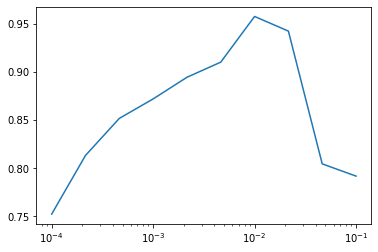

In [ ]:
plt.plot(Grid_search_results[0], -Grid_search_results[1]);
plt.xscale("log")

In [ ]:
def Random_grid_search(Npoints):
  a = np.random.rand(Npoints)
  learning_rates = np.interp(a, (a.min(), a.max()), (1e-4, 1e-1))
  accuracy_vals  = np.zeros((Npoints,1))
  for idx in range(learning_rates.shape[0]):
    accuracy_vals[idx,0] = fitness([learning_rates[idx]])  
  max_acc = np.max(-accuracy_vals)
  max_lr  = learning_rates[np.argmax(-accuracy_vals)] 
  return learning_rates, accuracy_vals, max_lr, max_acc

Random_search_results = Random_grid_search(10)

Epoch 1/5
250/250 [==============================] - 3s 8ms/step - loss: 8.3877 - accuracy: 0.7868 - val_loss: 6.8414 - val_accuracy: 0.7212
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 5.4380 - accuracy: 0.8655 - val_loss: 4.4355 - val_accuracy: 0.8407
Epoch 3/5
250/250 [==============================] - 2s 6ms/step - loss: 3.5757 - accuracy: 0.8916 - val_loss: 2.9526 - val_accuracy: 0.8650
Epoch 4/5
250/250 [==============================] - 2s 6ms/step - loss: 2.3750 - accuracy: 0.9119 - val_loss: 2.0304 - val_accuracy: 0.8615
Epoch 5/5
250/250 [==============================] - 2s 6ms/step - loss: 1.6007 - accuracy: 0.9252 - val_loss: 1.3722 - val_accuracy: 0.9028

Learning rate: 0.00436543
Accuracy: 90.28%

Epoch 1/5
250/250 [==============================] - 3s 8ms/step - loss: 2.3151 - accuracy: 0.8190 - val_loss: 1.0136 - val_accuracy: 0.5947
Epoch 2/5
250/250 [==============================] - 2s 6ms/step - loss: 0.7171 - accuracy: 0.8494 - val_loss

In [ ]:
print("learning rate",Random_search_results[2])
print("Accuracy",Random_search_results[3])

learning rate 0.007531463708813479
Accuracy 0.9522500038146973


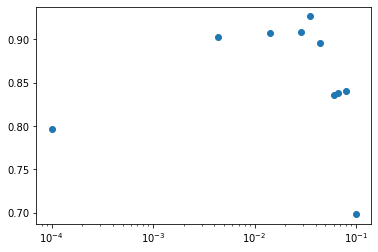

In [ ]:
fig = plt.figure()
plt.scatter(Random_search_results[0],-Random_search_results[1])
plt.xscale("log")

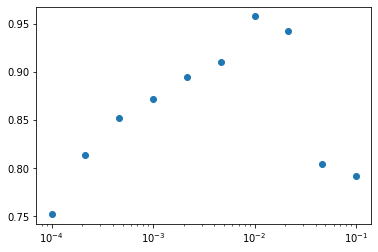

In [ ]:
fig = plt.figure()
plt.scatter(Grid_search_results[0],-Grid_search_results[1])
plt.xscale("log")

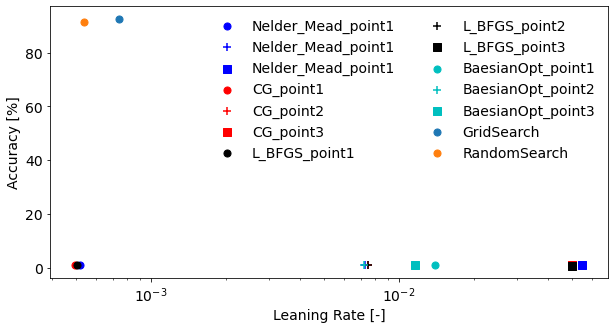

In [ ]:
fig = plt.figure(figsize=(10,5))
plt.scatter(Nelder_Mead_results[0].x[0],-Nelder_Mead_results[0].fun,marker='o',c='b',s=50, label = 'Nelder_Mead_point1')
plt.scatter(Nelder_Mead_results[1].x[0],-Nelder_Mead_results[1].fun,marker='+',c='b',s=50, label = 'Nelder_Mead_point1')
plt.scatter(Nelder_Mead_results[2].x[0],-Nelder_Mead_results[2].fun,marker='s',c='b',s=50, label = 'Nelder_Mead_point1')
plt.scatter(CG_results[0].x[0],-CG_results[0].fun,marker='o',c='r',s=50, label = 'CG_point1')
plt.scatter(CG_results[1].x[0],-CG_results[1].fun,marker='+',c='r',s=50, label = 'CG_point2')
plt.scatter(CG_results[2].x[0],-CG_results[2].fun,marker='s',c='r',s=50, label = 'CG_point3')
plt.scatter(L_BFGS_results[0].x[0],-L_BFGS_results[0].fun,marker='o',c='k',s=50,label ='L_BFGS_point1')
plt.scatter(L_BFGS_results[1].x[0],-L_BFGS_results[1].fun,marker='+',c='k',s=50,label ='L_BFGS_point2')
plt.scatter(L_BFGS_results[2].x[0],-L_BFGS_results[2].fun,marker='s',c='k',s=50,label ='L_BFGS_point3')
plt.scatter(gp_results[0].x[0],-gp_results[0].fun,marker='o',c='c',s=50,label ='BaesianOpt_point1')
plt.scatter(gp_results[1].x[0],-gp_results[1].fun,marker='+',c='c',s=50,label ='BaesianOpt_point2')
plt.scatter(gp_results[2].x[0],-gp_results[2].fun,marker='s',c='c',s=50,label ='BaesianOpt_point3')
plt.scatter(0.000744,92.6,s=50,label ='GridSearch')
plt.scatter(0.000538,91.51666,s=50,label ='RandomSearch')
plt.xlabel('Leaning Rate [-]')
plt.ylabel('Accuracy [%]')
plt.xscale("log")
plt.legend(frameon = False, ncol = 2)

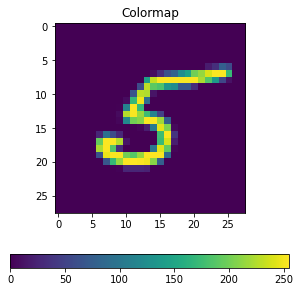

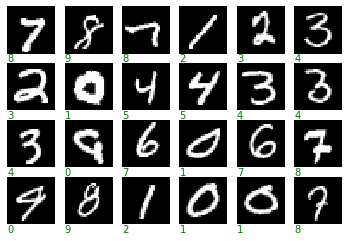

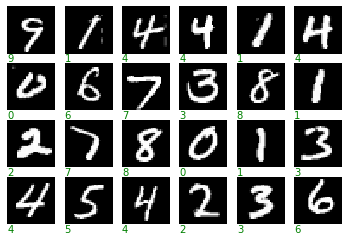

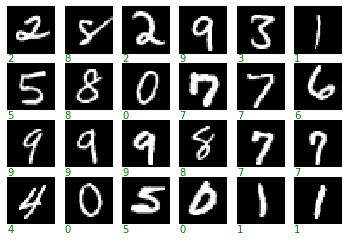

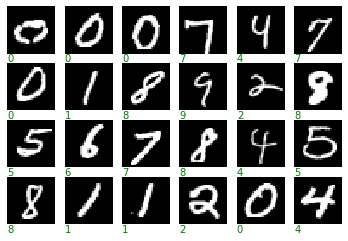

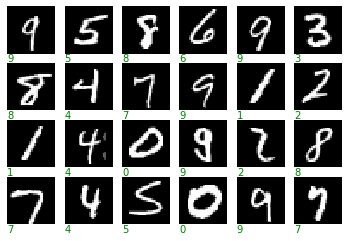

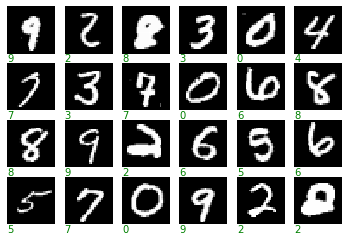

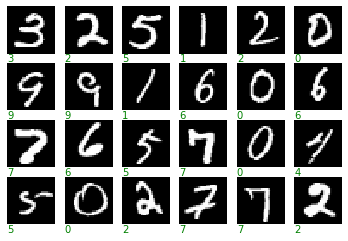

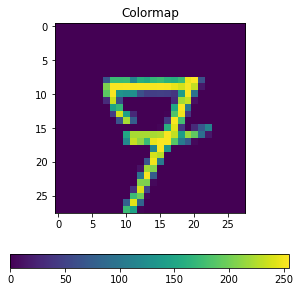

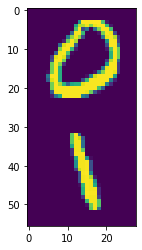

In [ ]:
# downloads data at first execution
(x_mnist_train, y_mnist_train), (x_mnist_test, y_mnist_test) = keras.datasets.mnist.load_data(path="mnist.npz")

## Explore scale to know if scaling is necessary ##
plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.title('Colormap')
plt.imshow(x_mnist_train[np.random.randint(0,x_mnist_train.shape[0])])
plt.colorbar(orientation="horizontal")
plt.grid(False)
plt.show()


#MNIST
## Plot some samples of the dataset with labels  ##
plot_some_samples(x_mnist_train, y_mnist_train)

## change labels to right ones in images
y_mnist_train = y_mnist_train.astype(np.float32) - 1
y_mnist_train = np.where(y_mnist_train==-1, 9, y_mnist_train)
y_mnist_train = y_mnist_train.astype(np.uint8)
y_mnist_test = y_mnist_test.astype(np.float32) - 1
y_mnist_test = np.where(y_mnist_test==-1, 9, y_mnist_test)
y_mnist_test = y_mnist_test.astype(np.uint8)

### plot sample to check if labeling is done properly
plot_some_samples(x_mnist_train, y_mnist_train)
plot_some_samples(x_mnist_test, y_mnist_test)

# shuffle 2 versions of the training set to build input
x_train_0, y_train_0    = shuffle(x_mnist_train, y_mnist_train)
x_train_1, y_train_1    = shuffle(x_mnist_train, y_mnist_train)
plot_some_samples(x_train_0, y_train_0)
plot_some_samples(x_train_1, y_train_1)

# shuffle 2 versions of the testing set to build input
x_test_0, y_test_0      = shuffle(x_mnist_test, y_mnist_test)
x_test_1, y_test_1      = shuffle(x_mnist_test, y_mnist_test)
plot_some_samples(x_test_0, y_test_0)
plot_some_samples(x_test_1, y_test_1)

# scale training data to 0,1
x_train_0 = x_train_0 / 255
x_train_1 = x_train_1 / 255
x_test_0  = x_test_0 / 255 
x_test_1 = x_test_1 / 255

## Explore scaled data to know if scaling is necessary ##
plt.figure(figsize=(5, 5))
plt.tight_layout()
plt.title('Colormap')
plt.imshow(x_mnist_train[np.random.randint(0,x_train_0.shape[0])])
plt.colorbar(orientation="horizontal")
plt.grid(False)
plt.show()

# horizentally append images from set 0 and 1 to create input images
x_train = cv2.hconcat([x_train_0, x_train_1])
plt.imshow(x_train[0])
x_test  = cv2.hconcat([x_test_0, x_test_1])
plt.imshow(x_test[0])

# create output labels
diff_train = y_train_0.astype(np.float32) - y_train_1.astype(np.float32)
diff_test  = y_test_0.astype(np.float32)   - y_test_1.astype(np.float32)

y_train = np.where(diff_train > 0, 1, diff_train)
y_train = np.where(y_train < 0, 0, y_train).astype(np.uint8)
y_test = np.where(diff_test > 0, 1, diff_test)
y_test = np.where(y_test < 0, 0, y_test).astype(np.uint8)

y_train = np.flip(keras.utils.to_categorical(y_train, num_classes=2), axis=1).astype(np.uint8)
y_test = np.flip(keras.utils.to_categorical(y_test, num_classes=2), axis=1).astype(np.uint8)

# define validation data
x_train, x_val, y_train, y_val= train_test_split(x_train, y_train, test_size=0.2, shuffle=False)

# reshape data, add 1 dimension because of CNN insput: 1 channel
x_train = x_train.reshape((x_train.shape[0], 56, 28, 1))
x_test = x_test.reshape((x_test.shape[0], 56, 28, 1))
x_val = x_val.reshape((x_val.shape[0], 56, 28, 1))

Epoch 1/20
750/750 [==============================] - 6s 7ms/step - loss: 4.3090 - accuracy: 0.8656 - val_loss: 1.4882 - val_accuracy: 0.8399
Epoch 2/20
750/750 [==============================] - 4s 6ms/step - loss: 0.6806 - accuracy: 0.9374 - val_loss: 0.4652 - val_accuracy: 0.9006
Epoch 3/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2876 - accuracy: 0.9540 - val_loss: 0.2591 - val_accuracy: 0.9547
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2466 - accuracy: 0.9595 - val_loss: 0.2401 - val_accuracy: 0.9581
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2401 - accuracy: 0.9630 - val_loss: 0.2405 - val_accuracy: 0.9628
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2468 - accuracy: 0.9624 - val_loss: 0.3126 - val_accuracy: 0.9367
Epoch 7/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2466 - accuracy: 0.9643 - val_loss: 0.2437 - val_accuracy: 0.9617
Epoch 

TypeError: ignored

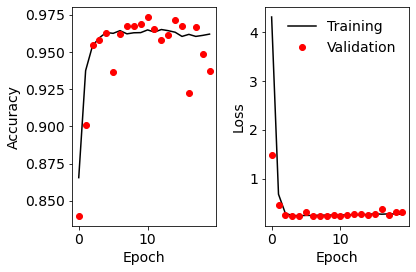

In [ ]:
model_NM = define_model()
opt = SGD(learning_rate=Nelder_Mead_results[1].x[0], momentum=0.9)
model_NM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
structure_NM =  model_NM.fit(x_train, y_train, 
                           validation_data=(x_val, y_val), 
                           epochs = 20, batch_size = 64)
accuracy = structure_NM.history['accuracy']
val_accuracy = structure_NM.history['val_accuracy']
loss = structure_NM.history['loss']
val_loss = structure_NM.history['val_loss']

plt.rcParams.update({'font.size': 14})

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(accuracy,c='k')
ax1.plot(val_accuracy,linestyle='',marker='o',c='r')
ax2.plot(loss,'-k')
ax2.plot(val_loss,linestyle='',marker='o',c='r')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax2.legend(['Training','Validation'],frameon=False)
fig.tight_layout()  

Epoch 1/20
750/750 [==============================] - 5s 6ms/step - loss: 4.2251 - accuracy: 0.8620 - val_loss: 1.3463 - val_accuracy: 0.8872
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 0.6523 - accuracy: 0.9356 - val_loss: 0.3546 - val_accuracy: 0.9477
Epoch 3/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2869 - accuracy: 0.9539 - val_loss: 0.2614 - val_accuracy: 0.9553
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2540 - accuracy: 0.9580 - val_loss: 0.3118 - val_accuracy: 0.9348
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2520 - accuracy: 0.9601 - val_loss: 0.2429 - val_accuracy: 0.9632
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2447 - accuracy: 0.9621 - val_loss: 0.2318 - val_accuracy: 0.9687
Epoch 7/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2560 - accuracy: 0.9601 - val_loss: 0.2665 - val_accuracy: 0.9608
Epoch 

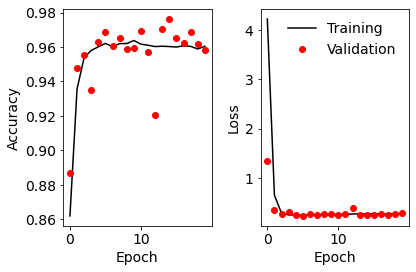

In [ ]:
model_CG = define_model()
opt = SGD(learning_rate=CG_results[1].x[0], momentum=0.9)
model_CG.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
structure_CG =  model_CG.fit(x_train, y_train, 
                           validation_data=(x_val, y_val), 
                           epochs = 20, batch_size = 64)
accuracy = structure_CG.history['accuracy']
val_accuracy = structure_CG.history['val_accuracy']
loss = structure_CG.history['loss']
val_loss = structure_CG.history['val_loss']

plt.rcParams.update({'font.size': 14})

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(accuracy,c='k')
ax1.plot(val_accuracy,linestyle='',marker='o',c='r')
ax2.plot(loss,'-k')
ax2.plot(val_loss,linestyle='',marker='o',c='r')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax2.legend(['Training','Validation'],frameon=False)
fig.tight_layout() 

Epoch 1/20
750/750 [==============================] - 6s 7ms/step - loss: 4.2509 - accuracy: 0.8589 - val_loss: 1.4108 - val_accuracy: 0.8489
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 0.6530 - accuracy: 0.9365 - val_loss: 0.3418 - val_accuracy: 0.9524
Epoch 3/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2884 - accuracy: 0.9529 - val_loss: 0.2472 - val_accuracy: 0.9603
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2453 - accuracy: 0.9590 - val_loss: 0.2317 - val_accuracy: 0.9653
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2508 - accuracy: 0.9604 - val_loss: 0.2474 - val_accuracy: 0.9653
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2542 - accuracy: 0.9604 - val_loss: 0.2403 - val_accuracy: 0.9672
Epoch 7/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2499 - accuracy: 0.9620 - val_loss: 0.2829 - val_accuracy: 0.9487
Epoch 

TypeError: ignored

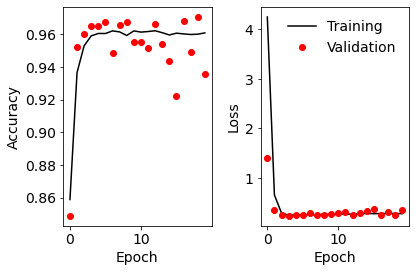

In [ ]:
model_BFGS = define_model()
opt = SGD(learning_rate= L_BFGS_results[1].x[0], momentum=0.9)
model_BFGS.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
structure_BFGS =  model_BFGS.fit(x_train, y_train, 
                           validation_data=(x_val, y_val), 
                           epochs = 20, batch_size = 64)
accuracy = structure_BFGS.history['accuracy']
val_accuracy = structure_BFGS.history['val_accuracy']
loss = structure_BFGS.history['loss']
val_loss = structure_BFGS.history['val_loss']

plt.rcParams.update({'font.size': 14})

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(accuracy,c='k')
ax1.plot(val_accuracy,linestyle='',marker='o',c='r')
ax2.plot(loss,'-k')
ax2.plot(val_loss,linestyle='',marker='o',c='r')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax2.legend(['Training','Validation'],frameon=False)
fig.tight_layout()  

Epoch 1/20
750/750 [==============================] - 5s 6ms/step - loss: 4.3217 - accuracy: 0.8635 - val_loss: 1.4498 - val_accuracy: 0.8648
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 0.6895 - accuracy: 0.9375 - val_loss: 0.3649 - val_accuracy: 0.9511
Epoch 3/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2856 - accuracy: 0.9549 - val_loss: 0.2483 - val_accuracy: 0.9591
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2436 - accuracy: 0.9601 - val_loss: 0.2352 - val_accuracy: 0.9623
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2391 - accuracy: 0.9624 - val_loss: 0.2350 - val_accuracy: 0.9671
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2499 - accuracy: 0.9607 - val_loss: 0.2310 - val_accuracy: 0.9704
Epoch 7/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2531 - accuracy: 0.9618 - val_loss: 0.2330 - val_accuracy: 0.9697
Epoch 

TypeError: ignored

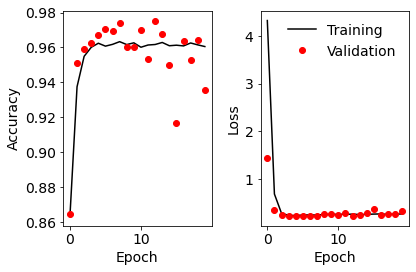

In [ ]:
model_gp = define_model()
opt = SGD(learning_rate= gp_results[1].x[0], momentum=0.9)
model_gp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
structure_gp =  model_gp.fit(x_train, y_train, 
                           validation_data=(x_val, y_val), 
                           epochs = 20, batch_size = 64)
accuracy = structure_gp.history['accuracy']
val_accuracy = structure_gp.history['val_accuracy']
loss = structure_gp.history['loss']
val_loss = structure_gp.history['val_loss']

plt.rcParams.update({'font.size': 14})

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(accuracy,c='k')
ax1.plot(val_accuracy,linestyle='',marker='o',c='r')
ax2.plot(loss,'-k')
ax2.plot(val_loss,linestyle='',marker='o',c='r')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax2.legend(['Training','Validation'],frameon=False)
fig.tight_layout()  

Epoch 1/20
750/750 [==============================] - 5s 6ms/step - loss: 4.2480 - accuracy: 0.8583 - val_loss: 1.3906 - val_accuracy: 0.8545
Epoch 2/20
750/750 [==============================] - 4s 6ms/step - loss: 0.6522 - accuracy: 0.9367 - val_loss: 0.3344 - val_accuracy: 0.9582
Epoch 3/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2872 - accuracy: 0.9520 - val_loss: 0.2651 - val_accuracy: 0.9514
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2503 - accuracy: 0.9588 - val_loss: 0.2187 - val_accuracy: 0.9725
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2486 - accuracy: 0.9594 - val_loss: 0.2305 - val_accuracy: 0.9720
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2547 - accuracy: 0.9591 - val_loss: 0.2491 - val_accuracy: 0.9628
Epoch 7/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2492 - accuracy: 0.9620 - val_loss: 0.2916 - val_accuracy: 0.9428
Epoch 

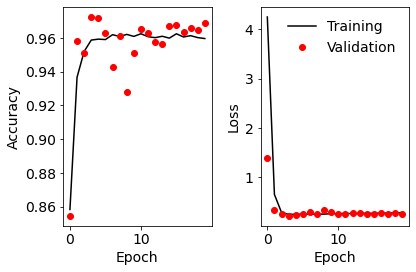

In [ ]:
model_cobyla = define_model()
opt = SGD(learning_rate= COBYLA_results[1].x, momentum=0.9)
model_cobyla.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
structure_cobyla =  model_cobyla.fit(x_train, y_train, 
                           validation_data=(x_val, y_val), 
                           epochs = 20, batch_size = 64)
accuracy = structure_cobyla.history['accuracy']
val_accuracy = structure_cobyla.history['val_accuracy']
loss = structure_cobyla.history['loss']
val_loss = structure_cobyla.history['val_loss']

plt.rcParams.update({'font.size': 14})

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(accuracy,c='k')
ax1.plot(val_accuracy,linestyle='',marker='o',c='r')
ax2.plot(loss,'-k')
ax2.plot(val_loss,linestyle='',marker='o',c='r')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax2.legend(['Training','Validation'],frameon=False)
fig.tight_layout() 

Epoch 1/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2749 - accuracy: 0.9619 - val_loss: 0.2593 - val_accuracy: 0.9623
Epoch 2/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2744 - accuracy: 0.9613 - val_loss: 0.2443 - val_accuracy: 0.9736
Epoch 3/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2799 - accuracy: 0.9600 - val_loss: 0.2669 - val_accuracy: 0.9680
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2767 - accuracy: 0.9612 - val_loss: 0.2635 - val_accuracy: 0.9689
Epoch 5/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2861 - accuracy: 0.9595 - val_loss: 0.2886 - val_accuracy: 0.9570
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2849 - accuracy: 0.9595 - val_loss: 0.2531 - val_accuracy: 0.9728
Epoch 7/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2774 - accuracy: 0.9600 - val_loss: 0.2777 - val_accuracy: 0.9619
Epoch 

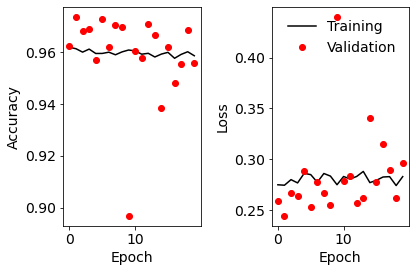

In [ ]:
model_grid = define_model()
opt = SGD(learning_rate= 0.01, momentum=0.9)
model_grid.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
structure_grid =  model_cobyla.fit(x_train, y_train, 
                           validation_data=(x_val, y_val), 
                           epochs = 20, batch_size = 64)
accuracy = structure_grid.history['accuracy']
val_accuracy = structure_grid.history['val_accuracy']
loss = structure_grid.history['loss']
val_loss = structure_grid.history['val_loss']

plt.rcParams.update({'font.size': 14})

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(accuracy,c='k')
ax1.plot(val_accuracy,linestyle='',marker='o',c='r')
ax2.plot(loss,'-k')
ax2.plot(val_loss,linestyle='',marker='o',c='r')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax2.legend(['Training','Validation'],frameon=False)
fig.tight_layout() 

Epoch 1/20
750/750 [==============================] - 5s 6ms/step - loss: 4.2570 - accuracy: 0.8605 - val_loss: 1.4817 - val_accuracy: 0.8117
Epoch 2/20
750/750 [==============================] - 4s 6ms/step - loss: 0.6532 - accuracy: 0.9343 - val_loss: 0.4318 - val_accuracy: 0.9104
Epoch 3/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2819 - accuracy: 0.9546 - val_loss: 0.2737 - val_accuracy: 0.9495
Epoch 4/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2515 - accuracy: 0.9574 - val_loss: 0.2395 - val_accuracy: 0.9647
Epoch 5/20
750/750 [==============================] - 4s 6ms/step - loss: 0.2470 - accuracy: 0.9601 - val_loss: 0.2596 - val_accuracy: 0.9582
Epoch 6/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2469 - accuracy: 0.9616 - val_loss: 0.2410 - val_accuracy: 0.9633
Epoch 7/20
750/750 [==============================] - 5s 6ms/step - loss: 0.2490 - accuracy: 0.9629 - val_loss: 0.2273 - val_accuracy: 0.9677
Epoch 

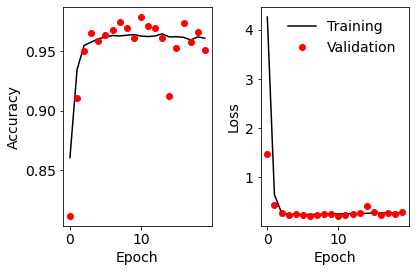

In [ ]:
model_rand = define_model()
opt = SGD(learning_rate= 0.00754, momentum=0.9)
model_rand.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
structure_rand =  model_rand.fit(x_train, y_train, 
                           validation_data=(x_val, y_val), 
                           epochs = 20, batch_size = 64)
accuracy = structure_rand.history['accuracy']
val_accuracy = structure_rand.history['val_accuracy']
loss = structure_rand.history['loss']
val_loss = structure_rand.history['val_loss']

plt.rcParams.update({'font.size': 14})

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2)
ax1.plot(accuracy,c='k')
ax1.plot(val_accuracy,linestyle='',marker='o',c='r')
ax2.plot(loss,'-k')
ax2.plot(val_loss,linestyle='',marker='o',c='r')

ax1.set_xlabel('Epoch')
ax2.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Loss')

ax2.legend(['Training','Validation'],frameon=False)
fig.tight_layout() 